In [25]:
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from ucimlrepo import fetch_ucirepo
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, linear_model, metrics, preprocessing, neural_network, model_selection, svm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy import spatial
from tqdm.notebook import tqdm

In [16]:
# %matplotlib widget

In [17]:
spambase = fetch_ucirepo(id=94)

spam = pd.DataFrame(spambase['data']['features'])
spam['target'] = spambase['data']['targets']

spam.sample(5, random_state=0)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
991,0.1,0.20,1.01,0.0,0.80,0.80,0.5,0.00,0.8,0.10,...,0.000,0.111,0.000,0.491,0.158,0.015,8.550,669,1351,1
2565,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,...,0.000,0.552,0.000,0.000,0.000,0.000,1.000,1,4,0
1906,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,1.666,4,15,0
1471,0.0,0.82,0.32,0.0,1.14,0.32,0.0,0.16,0.0,0.65,...,0.000,0.000,0.000,0.000,0.290,0.029,2.257,13,158,1
1813,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,...,0.022,0.022,0.019,0.022,0.022,0.022,3.482,5,5902,0


In [18]:
print(f"Dataset: {spambase.metadata.name}")
print(f"Задача: {spambase.metadata.abstract}")
print(f"Количество признаков: {spambase.metadata.num_features}")
print(f"Количество объектов выборки: {spambase.metadata.num_instances}")

Dataset: Spambase
Задача: Classifying Email as Spam or Non-Spam
Количество признаков: 57
Количество объектов выборки: 4601


# data visualization

The last 3 traits are of the most interst to us as they differ strongly from the rest. Let us also pick first 2 features and check for explicit dependencies 

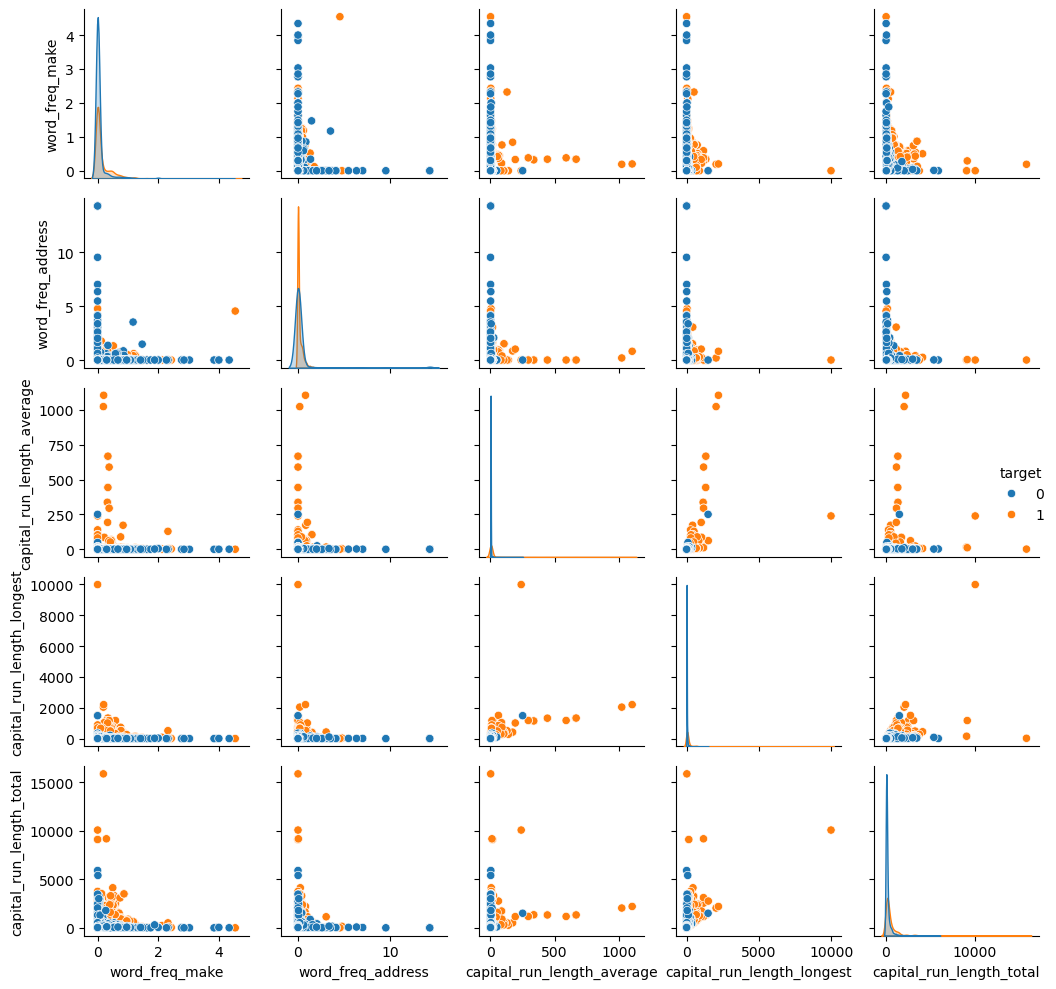

In [19]:
def visualize_data(dataset):
    features = list(dataset.columns)[:2] + list(dataset.columns)[-4:]
    sns.pairplot(dataset[features], hue='target', height=2)
    plt.tight_layout()
    plt.show()
visualize_data(spam)

As we can see both classes look very similar but we already can derive some trends:
 - Non-spam letters contain shorter average sequences of words starting with capital letters
 - Non-spam letters contain shorter longest sequences of consequent capital letters

# Feature normalization

In [20]:
features = list(spam.columns)[:-1]
scaler = preprocessing.StandardScaler().fit(spam[features])
spam[features] = scaler.transform(spam[features])

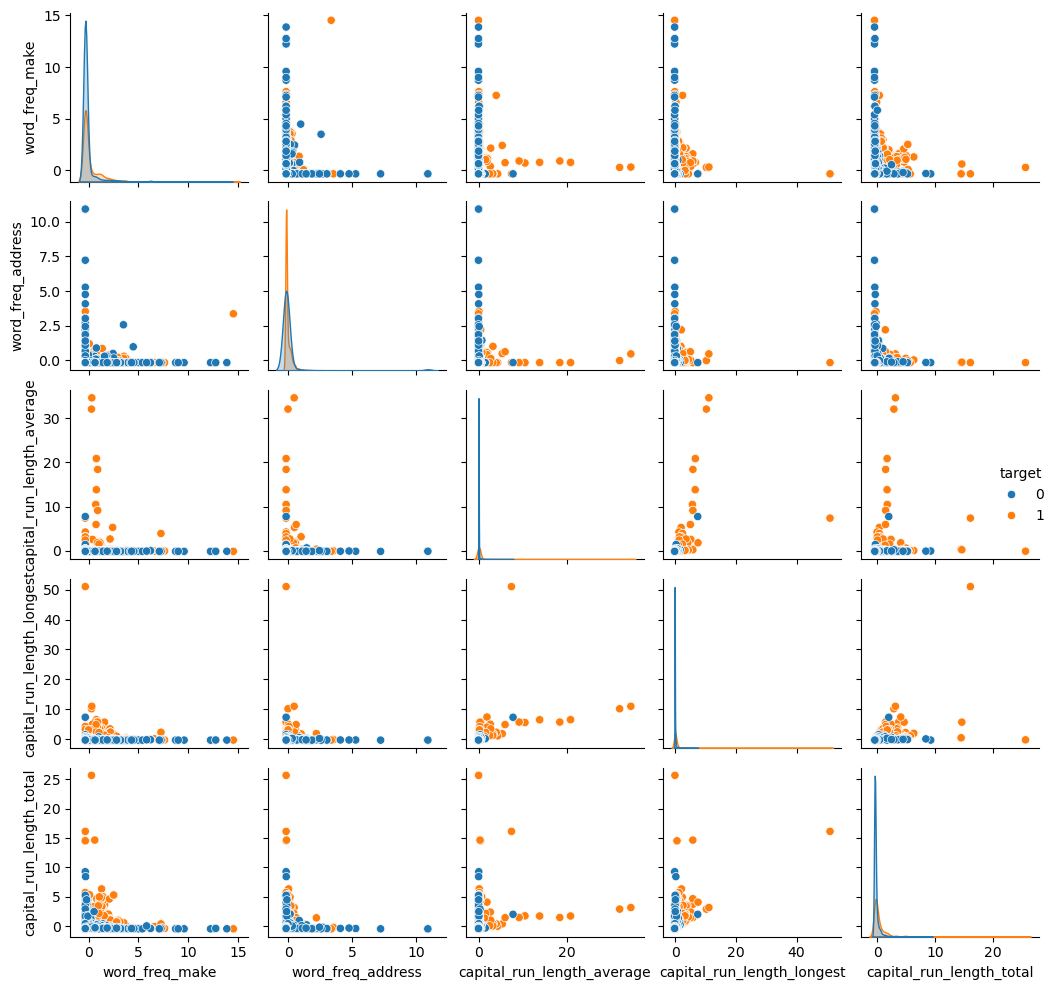

In [21]:
visualize_data(spam)

In [22]:
xs = spam.iloc[:, spam.columns != 'target'].values
ys = spam.iloc[:, spam.columns == 'target'].values.reshape(-1)
ys = np.array(ys)
x_train, x_test, y_train, y_test = model_selection.train_test_split(xs, ys, test_size=0.05, random_state=0)

# K-Neigbors

In [23]:
n_neighbors = 10
def get_k_neighbors_models(n, xs, ys):
    models = []
    for n_neighbors in range(1, n):
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(xs, ys)
        models.append(model)
    return models
models = get_k_neighbors_models(n_neighbors, x_train, y_train)
for idx, model in enumerate(models):
    y_result = model.predict(x_test)
    print(f"{idx + 1} nearest neighbors accuracy: {metrics.accuracy_score(y_result, y_test)}")

1 nearest neighbors accuracy: 0.9393939393939394
2 nearest neighbors accuracy: 0.9264069264069265
3 nearest neighbors accuracy: 0.935064935064935
4 nearest neighbors accuracy: 0.9264069264069265
5 nearest neighbors accuracy: 0.9177489177489178
6 nearest neighbors accuracy: 0.9134199134199135
7 nearest neighbors accuracy: 0.9090909090909091
8 nearest neighbors accuracy: 0.9090909090909091
9 nearest neighbors accuracy: 0.9264069264069265


### Model analysis
As we can see K-neighbors method gives pretty accurate estimations of which letters can be considered spam.
The accuracy fluctuates from the number of neighborst but only a little bit

# Perceptron

In [32]:
n_features = x_train.shape[1]
max_iterations = 1000
default_alpha = 0.001

perceptron_search = model_selection.GridSearchCV(estimator=neural_network.MLPClassifier(max_iter=max_iterations), n_jobs=-1, param_grid={
    "hidden_layer_sizes" : [(), (n_features), (n_features,)*2, (n_features,)*3],
    "activation" : ["logistic", "tanh", "relu"], "solver" : ["lbfgs", "sgd", "adam"],
    "alpha" : np.linspace(default_alpha, default_alpha  * 10, 3)
})

perceptron_search.fit(x_train, y_train)
prediction = perceptron_search.predict(x_test)
score = metrics.accuracy_score(y_test, prediction)

/nix/store/1rkh6sqpib9zx3f7w8ccq4svfhay645p-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/nix/store/1rkh6sqpib9zx3f7w8ccq4svfhay645p-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/nix/store/1rkh6sqpib9zx3f7w8ccq4svfhay645p-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converg

In [34]:
print(f"Optimal parameters: {perceptron_search.best_params_}")
print(f"Prediction of the optimal model: {prediction}")
print(f"Test answers:                    {y_test}")
print(f"Accuracy of the optimal model: {score}")

Optimal parameters: {'activation': 'relu', 'alpha': 0.0055000000000000005, 'hidden_layer_sizes': 57, 'solver': 'adam'}
Prediction of the optimal model: [1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1
 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0
 1 1 0 1 0 0 1 1 0]
Test answers:                    [1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1
 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1
 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 

## Model analysis
As we can see, the accuracy of perceptron is on par with k-neighbors and potential functions. We can correctly determine spam-ness of the letter in 92% of total cases

# Potential functions

In [29]:
class PotentialFunctions(object):
    def __init__(self, h):
        self.X = None
        self.Y = None
        self.gammas = None
        self.h = h
    def __K(self, x):
        return 1 / (1 + x)
    def predict(self, X):
        w = (self.gammas * self.__K(spatial.distance.cdist(X, self.X) / self.h)).T
        scores = []
        for y in np.unique(self.Y):
            scores.append(np.sum(w[np.where(self.Y==y)[0]], axis=0))
        return np.argmax(np.vstack(scores), axis=0)
    
    def fit(self, X, Y, epoch=10):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.gammas = np.zeros_like(Y)
        for _ in range(epoch):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gammas[i] += 1

In [34]:
accuracies = {}
h_range = list(np.linspace(0.01, 10.0, 20))
for h in h_range:
    pfm_model = PotentialFunctions(h)
    pfm_model.fit(x_train, y_train)
    y_pred_pfm = pfm_model.predict(x_test)
    accuracies[h] = metrics.accuracy_score(y_test, y_pred_pfm)

In [40]:
for h, acc in sorted(accuracies.items(), key= lambda pair: pair[1]):
    print(f"h: {h:.4f}, accuracy: {acc:.4f}")

h: 9.4742, accuracy: 0.9048
h: 10.0000, accuracy: 0.9048
h: 4.7421, accuracy: 0.9091
h: 5.7937, accuracy: 0.9091
h: 5.2679, accuracy: 0.9134
h: 1.5874, accuracy: 0.9177
h: 3.1647, accuracy: 0.9177
h: 6.8453, accuracy: 0.9177
h: 7.3711, accuracy: 0.9177
h: 3.6905, accuracy: 0.9221
h: 6.3195, accuracy: 0.9221
h: 0.5358, accuracy: 0.9264
h: 1.0616, accuracy: 0.9264
h: 7.8968, accuracy: 0.9264
h: 8.4226, accuracy: 0.9264
h: 8.9484, accuracy: 0.9264
h: 2.1132, accuracy: 0.9307
h: 4.2163, accuracy: 0.9307
h: 2.6389, accuracy: 0.9351
h: 0.0100, accuracy: 0.9394


### Model analysis
As we can see potential functions method gives pretty accurate results too. Though they very unpredictably iwth the value of h. Those fluctuations are small and be considered a systematical error

# Results
All of the given models (k-neighbors, perceptron and potential functions) give good prediction of whether or not the letter can be considered "spam". All of the accuracies measured are in the lower 90s. We can't select one model that gives the best results as they all arer very good. Though it is not 100% accurate. I can guess that since the dataset is relatively big (~5000 cases) we are dealing with overfitting.